In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

# Load Data

In [79]:
# Read pickle data
file_path = "vs_profiles.pkl"

with open(file_path, "rb") as f:
    data = pickle.load(f)

# Extract the data from dictionary
Vs_data_array = []

for key in data.keys():
    Vs_data_array.append(data[key][1])

In [80]:
# Extract sequences and their lengths from Vs_data_array
Vs_data_lengths = [len(seq) for seq in Vs_data_array]

# Convert Vs_data_array to PyTorch tensors
Vs_data_tensors = [torch.tensor(seq, dtype=torch.float32).unsqueeze(-1) for seq in Vs_data_array]

# Get the max_length
max_length = max(Vs_data_lengths)
print(f"Max length of sequences: {max_length}")


Max length of sequences: 4519


In [81]:
# Custom Dataset for Vs_data
class VsDataset(torch.utils.data.Dataset):
    def __init__(self, data, lengths):
        self.data = data
        self.lengths = lengths

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.lengths[idx]


In [82]:
# Create the dataset
from torch.nn.utils.rnn import pad_sequence

vs_dataset = VsDataset(Vs_data_tensors, Vs_data_lengths)

# Split the dataset into training, validation, and testing sets
train_size = int(0.8 * len(vs_dataset))
val_size = int(0.1 * len(vs_dataset))
test_size = len(vs_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(vs_dataset, [train_size, val_size, test_size])

# Custom collate function for padding and sorting
def vs_collate_fn(batch):
    # Sort the batch by sequence length in descending order
    batch.sort(key=lambda x: x[1], reverse=True)
    sequences, lengths = zip(*batch)

    # Pad the sequences
    padded_sequences = pad_sequence(sequences, batch_first=True)

    return padded_sequences, list(lengths)

# Create DataLoaders for each dataset
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=vs_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=vs_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=vs_collate_fn)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

Training set size: 1895
Validation set size: 236
Testing set size: 238


# Model

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.utils.rnn as rnn_utils
import matplotlib.pyplot as plt # Optional: for plotting

# --- Configuration ---
# ELEMENT_DIM = 1      # Dimension of a single element in the 1D array (it's 1 for a simple array of floats)
HIDDEN_DIM = 128      # Hidden dimension of the GRU
NUM_LAYERS = 2       # Number of GRU layers
LR = 0.001           # Learning rate
EPOCHS = 100
BATCH_SIZE = 32
MAX_SEQ_LEN = max_length    # Define a reasonable maximum length for padding
# You might need to find the actual max length in your dataset
# For dummy data, we'll define it.

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Autoregressive Model (GRU-based) ---
class AutoregressiveModel(nn.Module):
    def __init__(self, hidden_dim, num_layers):
        super(AutoregressiveModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # GRU layer: input size is the dimension of one element (1), output size is hidden_dim
        self.gru = nn.GRU(input_size=1,
                          hidden_size=hidden_dim,
                          num_layers=num_layers,
                          batch_first=True) # batch_first=True means input/output shape is (batch, seq_len, feature)

        # Output layer: Maps GRU hidden state to the prediction for the next element's value
        self.fc = nn.Linear(hidden_dim, 1) # Output size is dimension of one element (1)

    def forward(self, sequences, sequence_lengths):
        """
        Args:
            sequences (torch.Tensor): Padded batch of sequences (batch_size, max_seq_len, 1)
            sequence_lengths (list): List of original lengths of sequences in the batch
        """
        # Debugging: Print input shapes
        #print(f"Input sequences shape: {sequences.shape}")
        #print(f"Sequence lengths: {sequence_lengths}")

        # Pack padded sequences for efficient RNN processing
        packed_input = rnn_utils.pack_padded_sequence(sequences, sequence_lengths, batch_first=True, enforce_sorted=False)

        # Pass through GRU
        packed_output, _ = self.gru(packed_input)

        # Pad the packed output back to the original padded length
        # output shape: (batch_size, max_seq_len, hidden_dim)
        output, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)

        # Debugging: Print GRU output shape
        #print(f"GRU output shape: {output.shape}")

        # Apply the linear layer to the GRU output at each time step
        # The linear layer predicts the *next* element's value
        # predictions shape: (batch_size, max_seq_len, 1)
        predictions = self.fc(output)

        # Debugging: Print predictions shape
        #print(f"Predictions shape: {predictions.shape}")

        return predictions

    def generate(self, start_sequence, num_steps_to_generate):
        """
        Generates a sequence autoregressively.

        Args:
            start_sequence (torch.Tensor): The initial sequence to start generation from.
                                         Shape: (1, current_seq_len, 1)
            num_steps_to_generate (int): How many steps to generate after the start_sequence.

        Returns:
            torch.Tensor: The generated sequence including the start_sequence.
                          Shape: (1, current_seq_len + num_steps_to_generate, 1)
        """
        self.eval() # Set model to evaluation mode
        with torch.no_grad():
            # Ensure start_sequence is on the correct device and has shape (1, seq_len, 1)
            start_sequence = start_sequence.unsqueeze(0).unsqueeze(-1).to(device) if start_sequence.ndim == 1 else start_sequence.to(device)
            if start_sequence.ndim == 2: start_sequence = start_sequence.unsqueeze(-1) # Add feature dim if missing

            generated_sequence = start_sequence.clone()
            hidden = None # Initial hidden state is zero by default for GRU if not provided

            current_input = start_sequence[:, -1:, :] # Start with the last element of the start sequence

            for _ in range(num_steps_to_generate):
                # Pass only the current input element through the GRU to get the next prediction
                # output shape: (1, 1, hidden_dim)
                output, hidden = self.gru(current_input, hidden)

                # Predict the value of the next element
                # prediction shape: (1, 1, 1)
                prediction = self.fc(output)

                # The predicted value is the next element.
                # For continuous data, we often just take the prediction directly.
                next_element = prediction

                # Append the generated element
                generated_sequence = torch.cat((generated_sequence, next_element), dim=1)

                # The next input to the GRU is the element we just generated
                current_input = next_element

            return generated_sequence.squeeze(-1) # Remove the last dimension of size 1


Using device: cuda


In [84]:
# --- Initialize Model, Loss Function, and Optimizer ---
model = AutoregressiveModel(HIDDEN_DIM, NUM_LAYERS).to(device)

# MSE Loss for predicting continuous values
criterion = nn.MSELoss(reduction='none') # Use reduction='none' to apply masking

optimizer = optim.Adam(model.parameters(), lr=LR)

print("Autoregressive model initialized.")

Autoregressive model initialized.


In [ ]:
# --- Training Loop with Validation and Loss Storage ---
print("Starting training...")

# Initialize lists to store losses
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    total_train_loss = 0
    num_train_batches = 0

    for batch_sequences_padded, batch_lengths in train_loader:
        batch_sequences_padded = batch_sequences_padded.to(device)

        # Autoregressive task: predict x_i+1 from x_i and previous context
        inputs = batch_sequences_padded[:, :-1, :]  # Shape (batch, seq_len-1, 1)
        targets = batch_sequences_padded[:, 1:, :]  # Shape (batch, seq_len-1, 1)

        # Adjust sequence lengths to match the reduced input size
        adjusted_lengths = [length - 1 for length in batch_lengths]

        # Pass through the model
        predictions = model(inputs, adjusted_lengths)

        # Create a mask for the loss
        mask = torch.zeros_like(targets, dtype=torch.bool).to(device)
        for row, length in enumerate(adjusted_lengths):
            mask[row, :length, :] = True

        # Calculate loss
        element_loss = criterion(predictions, targets)
        masked_loss = element_loss * mask.float()
        loss = masked_loss.sum() / mask.sum()

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        num_train_batches += 1

    avg_train_loss = total_train_loss / num_train_batches
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    total_val_loss = 0
    num_val_batches = 0

    with torch.no_grad():
        for batch_sequences_padded, batch_lengths in val_loader:
            batch_sequences_padded = batch_sequences_padded.to(device)

            # Autoregressive task: predict x_i+1 from x_i and previous context
            inputs = batch_sequences_padded[:, :-1, :]  # Shape (batch, seq_len-1, 1)
            targets = batch_sequences_padded[:, 1:, :]  # Shape (batch, seq_len-1, 1)

            # Adjust sequence lengths to match the reduced input size
            adjusted_lengths = [length - 1 for length in batch_lengths]

            # Pass through the model
            predictions = model(inputs, adjusted_lengths)

            # Create a mask for the loss
            mask = torch.zeros_like(targets, dtype=torch.bool).to(device)
            for row, length in enumerate(adjusted_lengths):
                mask[row, :length, :] = True

            # Calculate loss
            element_loss = criterion(predictions, targets)
            masked_loss = element_loss * mask.float()
            loss = masked_loss.sum() / mask.sum()

            total_val_loss += loss.item()
            num_val_batches += 1

    avg_val_loss = total_val_loss / num_val_batches
    val_losses.append(avg_val_loss)

    # Log epoch metrics
    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

print("Training finished.")

Starting training...


Epoch [1/100], Train Loss: 1573862.3448, Val Loss: 1474274.4336
Epoch [2/100], Train Loss: 1519866.8651, Val Loss: 1460814.8789
Epoch [3/100], Train Loss: 1449275.0359, Val Loss: 1447865.1562
Epoch [4/100], Train Loss: 1404350.4609, Val Loss: 1435105.7617
Epoch [5/100], Train Loss: 1572419.5180, Val Loss: 1422148.5859
Epoch [6/100], Train Loss: 1543416.6099, Val Loss: 1409487.0156
Epoch [7/100], Train Loss: 1487389.4133, Val Loss: 1397200.4453
Epoch [8/100], Train Loss: 1490563.9779, Val Loss: 1384748.1953
Epoch [9/100], Train Loss: 1273643.5741, Val Loss: 1373530.6406
Epoch [10/100], Train Loss: 1343594.8167, Val Loss: 1362171.4570
Epoch [11/100], Train Loss: 1322732.9984, Val Loss: 1350657.5117
Epoch [12/100], Train Loss: 1347658.5883, Val Loss: 1339534.5449
Epoch [13/100], Train Loss: 1423867.5227, Val Loss: 1327865.5605
Epoch [14/100], Train Loss: 1316040.6839, Val Loss: 1317019.5762
Epoch [15/100], Train Loss: 1258866.8852, Val Loss: 1306318.3320
Epoch [16/100], Train Loss: 128310

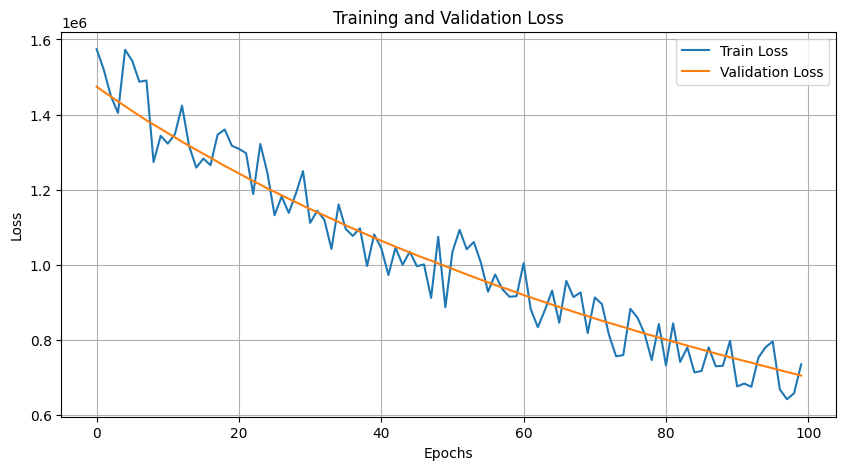

In [86]:
# --- Plot Losses ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Generating sample data...
Generated 5 samples (first sample shown):


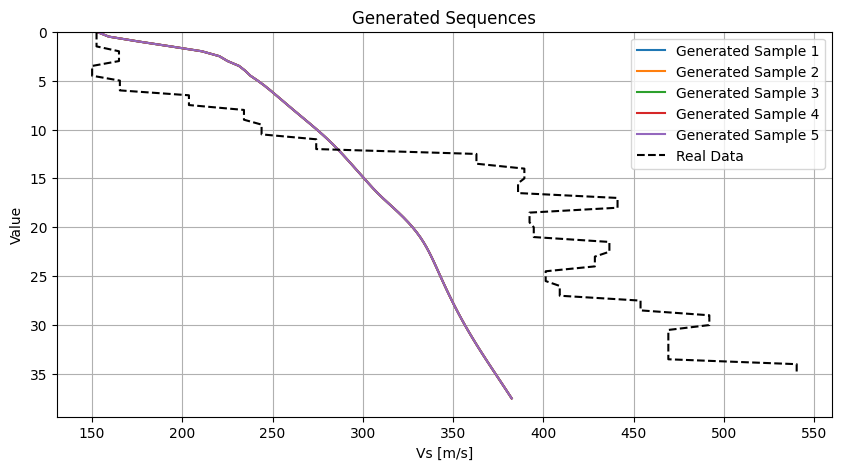

In [158]:
# --- Generate Sample Data ---
import random
print("\nGenerating sample data...")
# Start with a small sequence from the dataset to prime the generator
# Or you could start with a specific value (e.g., [0.0]) if that makes sense for your data
idx = random.randint(0, len(test_dataset) - 1) # Randomly select an index from the test dataset
start_seq, _ = test_dataset[idx] # Get the first sequence from the test dataset
start_seq = start_seq.to(device) # Move to device
start_element = start_seq[0, 0] # Take the first element of the first sequence
# Note: start_element should be of shape (1, 1) for the model to accept it as input

# Let's generate sequences of a specific length, starting from the first element of the first training sample
generate_length = len(start_seq) + 5 # Generate 5 more elements after the start element
num_generate_samples = 5

generated_samples = []
for _ in range(num_generate_samples):
    # Start with a single element to generate from
    initial_input = start_element.clone().unsqueeze(0) # Needs shape (1, 1, 1)
    generated_seq = model.generate(initial_input, generate_length - 1) # Generate length-1 steps after the start
    generated_samples.append(generated_seq.cpu().numpy())

print(f"Generated {num_generate_samples} samples (first sample shown):")

# --- Optional: Visualize samples ---
plt.figure(figsize=(10, 5))
for i, sample in enumerate(generated_samples):
    plt.plot(sample[0], np.arange(len(sample[0]))*0.5, label=f'Generated Sample {i+1}')

# Plot the real data for comparison (optional)
real_data = test_dataset[idx][0].cpu().numpy() # Get the first sequence from the test dataset
plt.plot(real_data, np.arange(len(real_data))*0.5, label='Real Data', linestyle='--', color='black')
plt.xlabel('Vs [m/s]')
plt.ylabel('Value')
plt.title('Generated Sequences')
plt.legend()
plt.grid(True)
plt.ylim(0, None)
plt.gca().invert_yaxis() # Invert y-axis if needed
plt.show()

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. ])